Region-based or Masked-CNN is an important model for object detection. 

Will use pretrained weights trained on rich dataset like MSCOCO to train our model using transfer learning.



I cloned kangaroo dataset which has two flders one contains images and other contains xml files which contains element called size (for image shape) and object (bounding boxes of the images). Will combine them to prepare a masked bounded image and will split it into train test.



In [1]:
#!pip install --upgrade tensorflow==1.15.3

In [17]:
#!pip install --upgrade keras=2.2.4
#!pip install --upgrade pip

In [18]:
#pip install --upgrade tensorflow====1.5

In [19]:
#pip show tensorflow

In [39]:
#pip install tensorflow

In [41]:
#pip install keras

In [27]:
## Testing on an image
from xml.etree import ElementTree

In [28]:
# extract_boxes() = will take the annotation filename as an argument, 
# extract the bounding box and image dimension details, and return them for use.

def extract_boxes(filename):
    # Will parse the xml files
    tree = ElementTree.parse(filename)

    # get the root of the document
    root = tree.getroot()

    #Will iterate to .//bndbox to fetch x,y,min and max value for bounding boxes in xml files.
    boxes = []
    for box in root.findall('.//bndbox'):
        xmin = int(box.find('xmin').text)
        xmax = int(box.find('xmax').text)
        ymax = int(box.find('ymax').text)
        ymin = int(box.find('ymin').text)
        coors = [xmin, ymin, xmax, ymax]
        boxes.append(coors)

    #find size - weight/height of image 
    width = int(root.find('.//size/width').text)
    height = int(root.find('.//size/height').text)
    
    return boxes, width, height


In [29]:
# extract details from an annotaion file
boxes, w, h = extract_boxes('C:/Users/p192/office_work/learnings/deep learnings/deep_learning_codes/Mask_RCNN/kangaroo/annots/00001.xml')

# summarize details
print(boxes, w, h)

[[233, 89, 386, 262], [134, 105, 341, 253]] 450 319


In [30]:
### Make dataset
# split into train and test set
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset

In [31]:
# class that defines and loads the kangaroo dataset
class KangarooDataset(Dataset):
	# load the dataset definitions
	def load_dataset(self, dataset_dir, is_train=True):
		# define one class
		self.add_class("dataset", 1, "kangaroo")
		# define data locations
		images_dir = dataset_dir + '/images/'
		annotations_dir = dataset_dir + '/annots/'
		# find all images
		for filename in listdir(images_dir):
			# extract image id
			image_id = filename[:-4]
			# skip bad images
			if image_id in ['00090']:
				continue
			# skip all images after 150 if we are building the train set
			if is_train and int(image_id) >= 150:
				continue
			# skip all images before 150 if we are building the test/val set
			if not is_train and int(image_id) < 150:
				continue
			img_path = images_dir + filename
			ann_path = annotations_dir + image_id + '.xml'
			# add to dataset
			self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

	# extract bounding boxes from an annotation file
	def extract_boxes(self, filename):
		# load and parse the file
		tree = ElementTree.parse(filename)
		# get the root of the document
		root = tree.getroot()
		# extract each bounding box
		boxes = list()
		for box in root.findall('.//bndbox'):
			xmin = int(box.find('xmin').text)
			ymin = int(box.find('ymin').text)
			xmax = int(box.find('xmax').text)
			ymax = int(box.find('ymax').text)
			coors = [xmin, ymin, xmax, ymax]
			boxes.append(coors)
		# extract image dimensions
		width = int(root.find('.//size/width').text)
		height = int(root.find('.//size/height').text)
		return boxes, width, height

	# load the masks for an image
	def load_mask(self, image_id):
		# get details of image
		info = self.image_info[image_id]
		# define box file location
		path = info['annotation']
		# load XML
		boxes, w, h = self.extract_boxes(path)
		# create one array for all masks, each on a different channel
		masks = zeros([h, w, len(boxes)], dtype='uint8')
		# create masks
		class_ids = list()
		for i in range(len(boxes)):
			box = boxes[i]
			row_s, row_e = box[1], box[3]
			col_s, col_e = box[0], box[2]
			masks[row_s:row_e, col_s:col_e, i] = 1
			class_ids.append(self.class_names.index('kangaroo'))
		return masks, asarray(class_ids, dtype='int32')

	# load an image reference
	def image_reference(self, image_id):
		info = self.image_info[image_id]
		return info['path']

# train set
train_set = KangarooDataset()
train_set.load_dataset('C:/Users/p192/office_work/learnings/deep learnings/deep_learning_codes/Mask_RCNN/kangaroo', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# test/val set
test_set = KangarooDataset()
test_set.load_dataset('C:/Users/p192/office_work/learnings/deep learnings/deep_learning_codes/Mask_RCNN/kangaroo', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 131
Test: 32


In [32]:
# Let's test on a sample image

# load an image

image_id = 1
image = train_set.load_image(0)
print(image.shape)

# load a mask
mask, class_ids = train_set.load_mask(image_id)
print(mask.shape)

(319, 450, 3)
(309, 550, 2)


here we have an image with two masks with size (309, 550)

In [33]:
class_ids

array([1, 1])

In [34]:
mask[:,:,0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [35]:
mask.shape

(309, 550, 2)

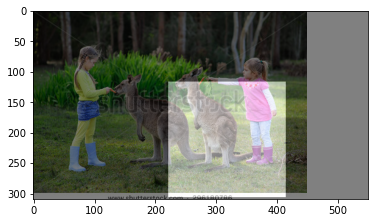

In [36]:
# Let's plot the image
import matplotlib.pyplot as plt

#image
plt.imshow(image)
#mask
plt.imshow(mask[:,:,1], cmap = 'gray', alpha = 0.5)
plt.show()

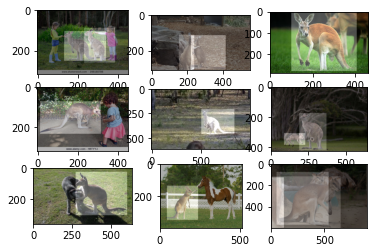

In [37]:
## First 10 images print

for i in range(9):
    plt.subplot(330 + 1 + i)
    image = train_set.load_image(i)
    #image show
    plt.imshow(image)
    
    #mask plot
    mask,_ = train_set.load_mask(i)    
    
    for j in range(mask.shape[2]):
        plt.imshow(mask[:,:,j], alpha = 0.3, cmap = 'gray')
plt.show()

In [38]:
## Getting image info
for imageids in train_set.image_ids[:5]:
    info = train_set.image_info[image_id]
    print(info)

{'id': '00002', 'source': 'dataset', 'path': 'C:/Users/p192/office_work/learnings/deep learnings/deep_learning_codes/Mask_RCNN/kangaroo/images/00002.jpg', 'annotation': 'C:/Users/p192/office_work/learnings/deep learnings/deep_learning_codes/Mask_RCNN/kangaroo/annots/00002.xml'}
{'id': '00002', 'source': 'dataset', 'path': 'C:/Users/p192/office_work/learnings/deep learnings/deep_learning_codes/Mask_RCNN/kangaroo/images/00002.jpg', 'annotation': 'C:/Users/p192/office_work/learnings/deep learnings/deep_learning_codes/Mask_RCNN/kangaroo/annots/00002.xml'}
{'id': '00002', 'source': 'dataset', 'path': 'C:/Users/p192/office_work/learnings/deep learnings/deep_learning_codes/Mask_RCNN/kangaroo/images/00002.jpg', 'annotation': 'C:/Users/p192/office_work/learnings/deep learnings/deep_learning_codes/Mask_RCNN/kangaroo/annots/00002.xml'}
{'id': '00002', 'source': 'dataset', 'path': 'C:/Users/p192/office_work/learnings/deep learnings/deep_learning_codes/Mask_RCNN/kangaroo/images/00002.jpg', 'annotat

the mask-rcnn library provides mrcnn.visualize.display_instances() function that will show a photograph with bounding boxes, masks, and class labels. Bounding boxes first needs to be extracted from the masks via the extract_bboxes() function.

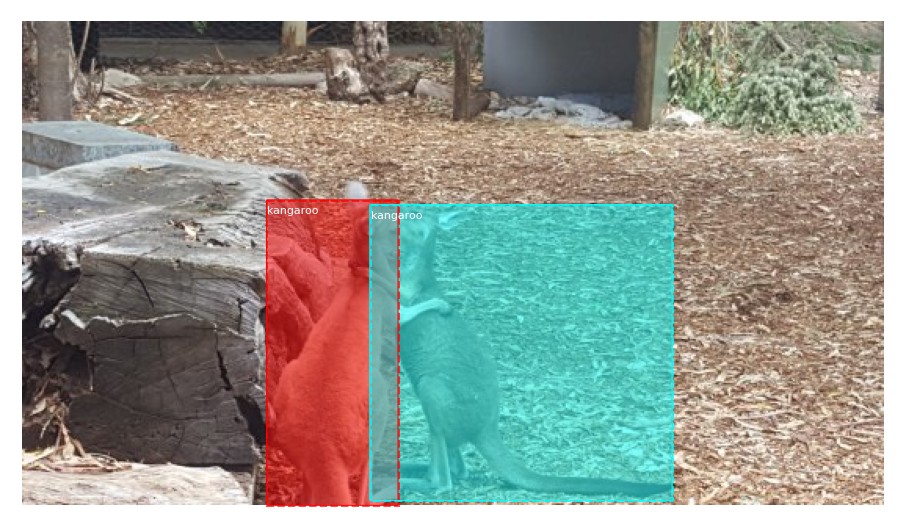

In [39]:
from mrcnn.utils import extract_bboxes
from mrcnn.visualize import display_instances

image_id = 1
image = train_set.load_image(image_id)
mask, class_ids = train_set.load_mask(image_id)

#extracting bounding boxes
bbox = extract_bboxes(mask)

#display images with mask and bounding boxes
display_instances(image, bbox, mask, class_ids, train_set.class_names)

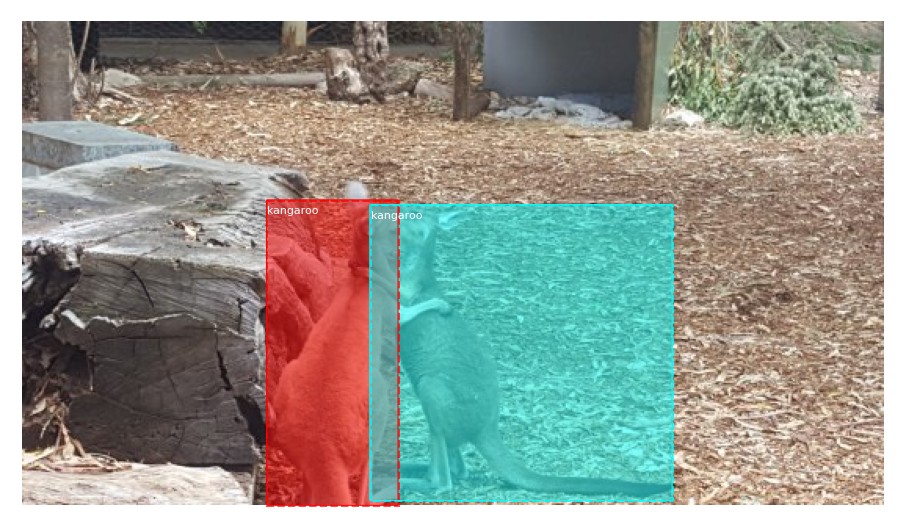

In [40]:
# display image with masks and bounding boxes
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes

# class that defines and loads the kangaroo dataset
class KangarooDataset(Dataset):
	# load the dataset definitions
	def load_dataset(self, dataset_dir, is_train=True):
		# define one class
		self.add_class("dataset", 1, "kangaroo")
		# define data locations
		images_dir = dataset_dir + '/images/'
		annotations_dir = dataset_dir + '/annots/'
		# find all images
		for filename in listdir(images_dir):
			# extract image id
			image_id = filename[:-4]
			# skip bad images
			if image_id in ['00090']:
				continue
			# skip all images after 150 if we are building the train set
			if is_train and int(image_id) >= 150:
				continue
			# skip all images before 150 if we are building the test/val set
			if not is_train and int(image_id) < 150:
				continue
			img_path = images_dir + filename
			ann_path = annotations_dir + image_id + '.xml'
			# add to dataset
			self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

	# extract bounding boxes from an annotation file
	def extract_boxes(self, filename):
		# load and parse the file
		tree = ElementTree.parse(filename)
		# get the root of the document
		root = tree.getroot()
		# extract each bounding box
		boxes = list()
		for box in root.findall('.//bndbox'):
			xmin = int(box.find('xmin').text)
			ymin = int(box.find('ymin').text)
			xmax = int(box.find('xmax').text)
			ymax = int(box.find('ymax').text)
			coors = [xmin, ymin, xmax, ymax]
			boxes.append(coors)
		# extract image dimensions
		width = int(root.find('.//size/width').text)
		height = int(root.find('.//size/height').text)
		return boxes, width, height

	# load the masks for an image
	def load_mask(self, image_id):
		# get details of image
		info = self.image_info[image_id]
		# define box file location
		path = info['annotation']
		# load XML
		boxes, w, h = self.extract_boxes(path)
		# create one array for all masks, each on a different channel
		masks = zeros([h, w, len(boxes)], dtype='uint8')
		# create masks
		class_ids = list()
		for i in range(len(boxes)):
			box = boxes[i]
			row_s, row_e = box[1], box[3]
			col_s, col_e = box[0], box[2]
			masks[row_s:row_e, col_s:col_e, i] = 1
			class_ids.append(self.class_names.index('kangaroo'))
		return masks, asarray(class_ids, dtype='int32')

	# load an image reference
	def image_reference(self, image_id):
		info = self.image_info[image_id]
		return info['path']

# train set
train_set = KangarooDataset()
train_set.load_dataset('C:/Users/p192/office_work/learnings/deep learnings/deep_learning_codes/Mask_RCNN/kangaroo', is_train=True)
train_set.prepare()
# define image id
image_id = 1
# load the image
image = train_set.load_image(image_id)
# load the masks and the class ids
mask, class_ids = train_set.load_mask(image_id)
# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, train_set.class_names)

Now since our data is loaded correctly I will fit Mask R-CNN model. Pretrained model on MS COCO dataset can be used and applied on kangaroo dataset using transfer learning.



Let's first define the model configuration. mrcnn.config.Config class allows to input config (Name) and number of classes (here 2)



In [41]:
# define a configuration for the model
from mrcnn.config import Config

# define a configuration for the model
class KangarooConfig(Config):
	# Give the configuration a recognizable name
	NAME = "kangaroo_cfg"
	# Number of classes (background + kangaroo)
	NUM_CLASSES = 1 + 1
	# Number of training steps per epoch
	STEPS_PER_EPOCH = 131

# prepare config
config = KangarooConfig()

In [42]:
from Mask_RCNN.mrcnn.model import MaskRCNN


In [45]:
# define the model
from mrcnn.model import MaskRCNN


model = MaskRCNN(mode='training', model_dir='./', config=config)

C:\ProgramData\Anaconda3\lib\site-packages\mask_rcnn-2.1-py3.9.egg\mrcnn\model.py:2359: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if os.name is 'nt':
C:\ProgramData\Anaconda3\lib\site-packages\mask_rcnn-2.1-py3.9.egg\mrcnn\model.py:2359: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if os.name is 'nt':


ModuleNotFoundError: No module named 'keras.engine'

In [26]:
# Will use MaskRCNN to define the model 

from Mask_RCNN.mrcnn.model import MaskRCNN

# define model
model = MaskRCNN(mode = 'training', model_dir = './', config = config)

# loading weights (mscoco) - will load all layers except 4 which will be removed and then added and trained again.
model.load_weights('mask_rcnn_coco.h5', by_name = True, exclude = ["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

# Fitting the model - traing the weights of output layers or 'heads'. 
'''
Here we are tuning the output layer and we can also train all layers if layers is set to 'all'.
'''
model.train(train_set, test_set, learning_rate = config.LEARNING_RATE, epochs = 5, layers = 'heads')


AttributeError: in user code:

    File "C:\Users\p192\office_work\learnings\deep learnings\projects\Mask_RCNN\mrcnn\model.py", line 682, in call  *
        outputs = utils.batch_slice(
    File "C:\ProgramData\Anaconda3\lib\site-packages\mask_rcnn-2.1-py3.9.egg\mrcnn\utils.py", line 820, in batch_slice  *
        output_slice = graph_fn(*inputs_slice)
    File "C:\Users\p192\office_work\learnings\deep learnings\projects\Mask_RCNN\mrcnn\model.py", line 591, in detection_targets_graph  *
        deltas = utils.box_refinement_graph(positive_rois, roi_gt_boxes)
    File "C:\ProgramData\Anaconda3\lib\site-packages\mask_rcnn-2.1-py3.9.egg\mrcnn\utils.py", line 202, in box_refinement_graph  *
        dh = tf.log(gt_height / height)

    AttributeError: module 'tensorflow' has no attribute 'log'


In [60]:
from mrcnn.config import MaskRCNN

ImportError: cannot import name 'MaskRCNN' from 'mrcnn.config' (C:\ProgramData\Anaconda3\lib\site-packages\mask_rcnn-2.1-py3.9.egg\mrcnn\config.py)

In [4]:
# display image with masks and bounding boxes
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes
from mrcnn.config import Config
from mrcnn.model import MaskRCNN


# class that defines and loads the kangaroo dataset
class KangarooDataset(Dataset):
	# load the dataset definitions
	def load_dataset(self, dataset_dir, is_train=True):
		# define one class
		self.add_class("dataset", 1, "kangaroo")
		# define data locations
		images_dir = dataset_dir + '/images/'
		annotations_dir = dataset_dir + '/annots/'
		# find all images
		for filename in listdir(images_dir):
			# extract image id
			image_id = filename[:-4]
			# skip bad images
			if image_id in ['00090']:
				continue
			# skip all images after 150 if we are building the train set
			if is_train and int(image_id) >= 150:
				continue
			# skip all images before 150 if we are building the test/val set
			if not is_train and int(image_id) < 150:
				continue
			img_path = images_dir + filename
			ann_path = annotations_dir + image_id + '.xml'
			# add to dataset
			self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

	# extract bounding boxes from an annotation file
	def extract_boxes(self, filename):
		# load and parse the file
		tree = ElementTree.parse(filename)
		# get the root of the document
		root = tree.getroot()
		# extract each bounding box
		boxes = list()
		for box in root.findall('.//bndbox'):
			xmin = int(box.find('xmin').text)
			ymin = int(box.find('ymin').text)
			xmax = int(box.find('xmax').text)
			ymax = int(box.find('ymax').text)
			coors = [xmin, ymin, xmax, ymax]
			boxes.append(coors)
		# extract image dimensions
		width = int(root.find('.//size/width').text)
		height = int(root.find('.//size/height').text)
		return boxes, width, height

	# load the masks for an image
	def load_mask(self, image_id):
		# get details of image
		info = self.image_info[image_id]
		# define box file location
		path = info['annotation']
		# load XML
		boxes, w, h = self.extract_boxes(path)
		# create one array for all masks, each on a different channel
		masks = zeros([h, w, len(boxes)], dtype='uint8')
		# create masks
		class_ids = list()
		for i in range(len(boxes)):
			box = boxes[i]
			row_s, row_e = box[1], box[3]
			col_s, col_e = box[0], box[2]
			masks[row_s:row_e, col_s:col_e, i] = 1
			class_ids.append(self.class_names.index('kangaroo'))
		return masks, asarray(class_ids, dtype='int32')

	# load an image reference
	def image_reference(self, image_id):
		info = self.image_info[image_id]
		return info['path']
    
class kangarooConfig(Config):
    # Give the configuration a recognizable name
    NAME = 'kangaroo_cfg'
    # number of classes (Kangaroo+background)
    NUM_CLASSES = 1+1
    # Training steps per epoch
    STEPS_PER_EPOCH = 131


# train set
train_set = KangarooDataset()
train_set.load_dataset('C:/Users/p192/office_work/learnings/deep learnings/deep_learning_codes/Mask_RCNN/kangaroo', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# prepare test/val set
test_set = KangarooDataset()
test_set.load_dataset('kangaroo', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

# define image id
image_id = 1
# load the image
image = train_set.load_image(image_id)
# load the masks and the class ids
mask, class_ids = train_set.load_mask(image_id)

# prepare config
config = KangarooConfig()
config.display()

# define model
model = MaskRCNN(mode = 'training', model_dir = './', config = config)

# loading weights (mscoco) - will load all layers except 4 which will be removed and then added and trained again.
model.load_weights('mask_rcnn_coco.h5', by_name = True, exclude = ["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

# Fitting the model - traing the weights of output layers or 'heads'. 
'''
Here we are tuning the output layer and we can also train all layers if layers is set to 'all'.
'''
model.train(train_set, test_set, learning_rate = config.LEARNING_RATE, epochs = 5, layers = 'heads')

C:\Users\p192\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\p192\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
C:\ProgramData\Anaconda3\lib\site-packages\mask_rcnn-2.1-py3.9.egg\mrcnn\model.py:2359: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\ProgramData\Anaconda3\lib\site-packages\mask_rcnn-2.1-py3.9.egg\mrcnn\model.py:2359: SyntaxWarning: "is" with a literal. Did you mean "=="?


ModuleNotFoundError: No module named 'keras.engine'

In [15]:
from mrcnn.model import MaskRCNN


C:\ProgramData\Anaconda3\lib\site-packages\mask_rcnn-2.1-py3.9.egg\mrcnn\model.py:2359: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if os.name is 'nt':
C:\ProgramData\Anaconda3\lib\site-packages\mask_rcnn-2.1-py3.9.egg\mrcnn\model.py:2359: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if os.name is 'nt':


ModuleNotFoundError: No module named 'keras.engine'